# Plotting COVID-19 data
> multiple ways to see it.

- toc: False 
- comments: true

In [1]:
#collapse
import numpy as np
import librosa 
import matplotlib.pyplot as plt
import pickle
from PyEMD import EMD
import numpy as np
import os
import pandas as pd
from scipy import signal
from sklearn.preprocessing import normalize
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import datetime
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from datetime import date

mpl.rcParams['figure.dpi'] = 100


In [2]:
#collapse
path_data = './my_data/'
path_store_figure = './figures/'

# df = pd.read_csv(path_data+'owid-covid-data.csv')  
url = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'
df = pd.read_csv(url)

dates = df['Date_reported'].unique()
dates = [datetime.datetime.strptime(ts, "%Y-%m-%d") for ts in dates]
dates.sort()
sorteddates = [datetime.datetime.strftime(ts, "%Y-%m-%d") for ts in dates]
data_1 = []
data_2 = []

for i in range(len(dates)):
    data_1.append(np.sum(df.loc[df['Date_reported']==sorteddates[i]]['Cumulative_deaths'].values))
    data_2.append(np.sum(df.loc[df['Date_reported']==sorteddates[i]]['Cumulative_cases'].values))
    
countries = df['Country'].unique()
all_country = np.zeros((len(countries),len(sorteddates)))
for i in range(len(countries)):
    temp = df[df['Country']==countries[i]]
    for j in range(len(sorteddates)):
        temp_1 = temp[temp['Date_reported']==sorteddates[j]]
        if len(temp_1):
            all_country[i,j] = temp_1['New_cases']

## Is there any periodicity over the time?

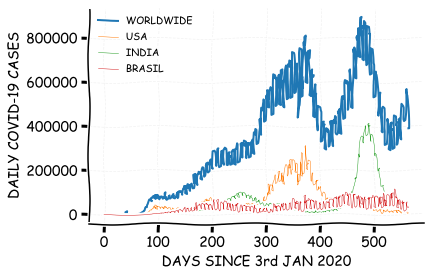

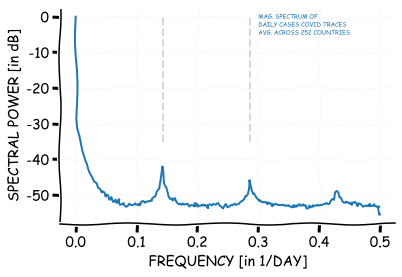

In [3]:
#collapse
S = []
for i in range(all_country.shape[0]):
#     s = all_country[np.where(countries=='United States of America')[0][0],:]
    s = np.nan_to_num(all_country[i,:])+1e-10
    s[s<0] = 0
    s = s/np.max(np.abs(s))
    S.append(s)

# take fft
nfft = 512
S = np.array(S)
S_fft = np.abs(np.fft.rfft(S,nfft,axis=1))
# normalize
for i in range(S.shape[0]):
    S_fft[i,:] = S_fft[i,:]/(np.max(S_fft[i,:])+10e-10)
#mean and std 
S_fft = 20*np.log10(S_fft+10e-20)
S_mu = np.mean(S_fft,axis=0)
S_std = np.std(S_fft,axis=0)/np.sqrt(all_country.shape[0])



# plot time series
fig = plt.subplots(figsize=[6,4])
plt.xkcd()
ax = plt.subplot(1,1,1)

clr_1 = 'tab:blue'
ax.plot(np.sum(all_country,axis=0),label='WORLDWIDE')
ax.plot(all_country[np.where(countries=='United States of America')[0][0],:],label='USA',linewidth=.5)
ax.plot(all_country[np.where(countries=='India')[0][0],:],label='INDIA',linewidth=.5)
ax.plot(all_country[np.where(countries=='Brazil')[0][0],:],label='BRASIL',linewidth=.5)
ax.legend(loc='upper left',fontsize=10,frameon=False)
ax.grid(axis='both', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('DAYS SINCE 3rd JAN 2020')
ax.set_ylabel('DAILY COVID-19 CASES')
# ax.text(.3,-5,'MAG. SPECTRUM OF \nDAILY CASES COVID TRACES \nAVG. ACROSS 252 COUNTRIES',\
#        c=clr_1,fontsize=6)
fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_trace_spectrum.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()


# plot spectrum
fig = plt.subplots(figsize=[6,4])
ax = plt.subplot(1,1,1)

fs = 1
faxis = np.arange(0,nfft/2+1)*fs/nfft
clr_1 = 'tab:blue'
ax.plot(faxis,S_mu,c=clr_1,linewidth=2)
# ax.plot(faxis,S_mu - S_std,color='r',alpha=.3,linewidth=.5)
# ax.plot(faxis,S_mu + S_std,color='r',alpha=.3,linewidth=.5)
ax.vlines(1/7, -35, 0, colors='gray', linestyles='--',alpha=.3)
ax.vlines(2/7, -35, 0, colors='gray', linestyles='--',alpha=.3)
ax.grid(axis='both', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('FREQUENCY [in 1/DAY]')
ax.set_ylabel('SPECTRAL POWER [in dB]')
ax.text(.3,-5,'MAG. SPECTRUM OF \nDAILY CASES COVID TRACES \nAVG. ACROSS 252 COUNTRIES',\
       c=clr_1,fontsize=6)
fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_trace_time_domain.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()


## Lets' visualize India data

In [4]:
#collapse
import json
import requests
import seaborn as sns
from scipy.signal import savgol_filter
sns.set(style="ticks")
mpl.rcParams.update(mpl.rcParamsDefault)

# get COVID data from COVID19india.ORG    
resp = requests.get('https://api.covid19india.org/data.json')
if resp.status_code != 200:
    # This means something went wrong.
    raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    
    
daily_testing = {}
daily_testing['totalsamplestested'] = []
daily_testing['samplereportedtoday'] = []
daily_testing['date'] = []
daily_testing['vaccinated'] = []


for item in resp.json()['tested']:
    if item['totalsamplestested']!='':
        daily_testing['totalsamplestested'].append(int(item['totalsamplestested']))
    else:
        daily_testing['totalsamplestested'].append(0)
        
    if item['totalindividualsvaccinated']!='':
        daily_testing['vaccinated'].append(int(item['totalindividualsvaccinated']))
    else:
        daily_testing['vaccinated'].append(0)
        
#     daily_testing['date'].append(item['updatetimestamp'])

daily_cases = {}
daily_cases['dailyconfirmed'] = []
daily_cases['dailydeceased'] = []
daily_cases['dailyrecovered'] = []
daily_cases['date'] = []


for item in resp.json()['cases_time_series']:
    daily_cases['dailyconfirmed'].append(int(item['dailyconfirmed']))
    daily_cases['dailydeceased'].append(int(item['dailydeceased']))
    daily_cases['dailyrecovered'].append(int(item['dailyrecovered']))
    daily_cases['date'].append(item['date'])
    
total_cases = {}
total_cases['totalconfirmed'] = []
total_cases['totaldeceased'] = []
total_cases['totalrecovered'] = []
total_cases['date'] = []

for item in resp.json()['cases_time_series']:
    total_cases['totalconfirmed'].append(int(item['totalconfirmed']))
    total_cases['totaldeceased'].append(int(item['totaldeceased']))
    total_cases['totalrecovered'].append(int(item['totalrecovered']))
    total_cases['date'].append(item['date'])

## As occurence-per-second ...

/Users/neeks/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: AutoMinorLocator does not work with logarithmic scale
/Users/neeks/miniconda2/envs/py36/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


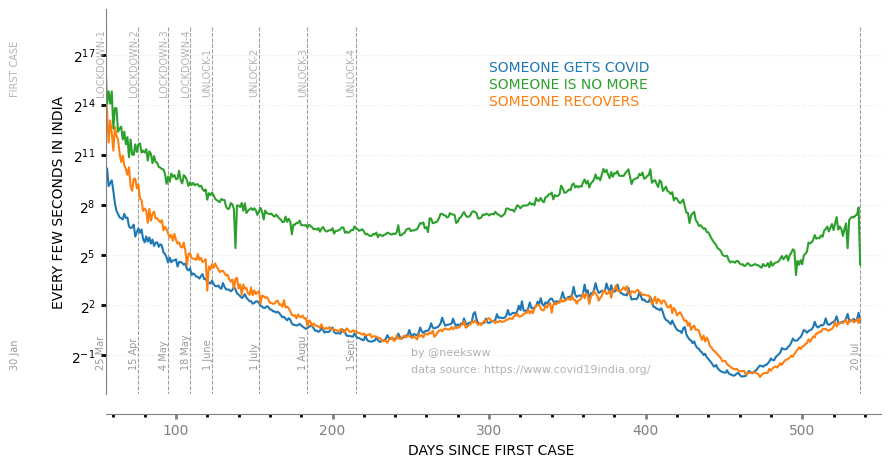

In [5]:
#collapse
fig = plt.subplots(figsize=(10,5))
clr_1 = "tab:blue"
clr_2 = "tab:orange"
clr_3 = "tab:green"

ax = plt.subplot(1,1,1)
ax.semilogy([24*60*60/i if i>0 else 0 for i in daily_cases['dailyconfirmed']],color=clr_1,label='SOMEONE BECOMES A PATIENT',
           basey=2)
ax.plot([24*60*60/i if i>0 else 0 for i in daily_cases['dailyrecovered']],color=clr_2,label='SOMEONE RECOVERS')
ax.plot([24*60*60/i if i>0 else 0 for i in daily_cases['dailydeceased']],color=clr_3,label='SOMEONE DIES')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.grid(axis='y', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -.05))
ax.yaxis.set_ticks_position('left')
ax.text(300,2**16,'SOMEONE GETS COVID',fontsize=10,color=clr_1)
ax.text(300,2**15,'SOMEONE IS NO MORE',fontsize=10,color=clr_3)
ax.text(300,2**14,'SOMEONE RECOVERS',fontsize=10,color=clr_2)



xticks = [0,55,76,95,109,123,153,184,215,len(total_cases['totalconfirmed'])-1]
cnt = 0
str_lock = ['FIRST CASE','LOCKDOWN-1','LOCKDOWN-2','LOCKDOWN-3','LOCKDOWN-4','UNLOCK-1','UNLOCK-2','UNLOCK-3'\
            ,'UNLOCK-4',' ']
xlabels = []
ind_1 = 6

for i in xticks:
    ax.vlines(i,min(total_cases['totaldeceased']),max(total_cases['totaldeceased']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax.vlines(i,min(total_cases['totaldeceased']),max(total_cases['totaldeceased']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax.text(x=i-6,y=25000,s=str_lock[cnt],rotation=90,fontsize=7,color='gray',alpha=0.6)
    if  i == len(total_cases['totalconfirmed']):
        xlabels.append(total_cases['date'][-1][:ind_1])
    else:
        xlabels.append(total_cases['date'][xticks[cnt]][:ind_1])
    ax.text(i-6,.3,xlabels[cnt],rotation=90,fontsize=7,color='gray',alpha=0.8)
    cnt = cnt+1
ax.set_ylabel('EVERY FEW SECONDS IN INDIA',fontsize=10)
ax.set_xlabel('DAYS SINCE FIRST CASE ',fontsize=10)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('gray')
ax.spines["left"].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.text(250,.5,'by @neeksww',fontsize=8,color='gray',alpha=0.6)
ax.text(250,.25,'data source: https://www.covid19india.org/',fontsize=8,color='gray',alpha=0.6)

ax.set_xlim(55,550)
fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_status_time_whole_india.'+fmt, dpi=300, format=fmt,transparent=True,bbox_inches='tight')
plt.show()


## As cases ...

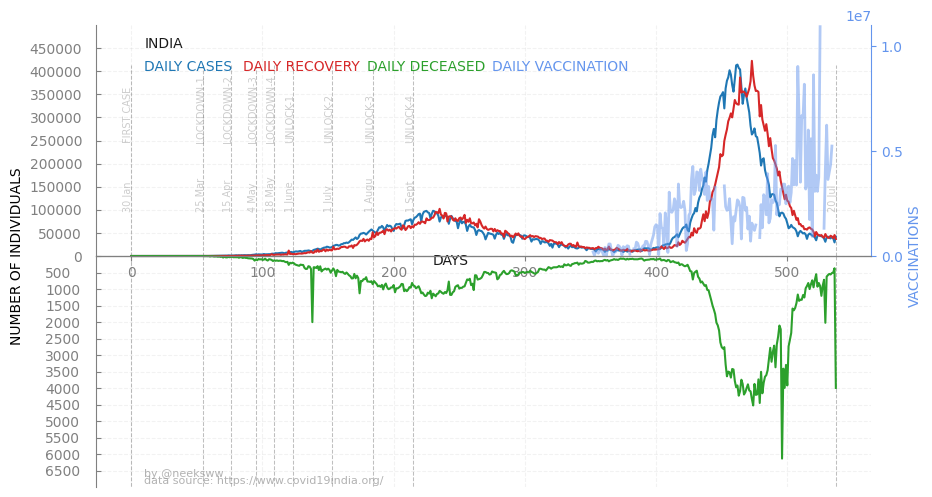

In [6]:
#collapse
# get vaccination data
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv'
df = pd.read_csv(url)
df = df[df['location']=='India'].reset_index(drop=True)
vals = df['total_vaccinations'].values

d_0 = date(2020, 1, 30)
d_1 = date(int(df['date'][0].split('-')[0]), int(df['date'][0].split('-')[1][1]), int(df['date'][0].split('-')[2]))
d_2 = date(int(df['date'][len(df)-1].split('-')[0]), int(df['date'][len(df)-1].split('-')[1][1]), int(df['date'][len(df)-1].split('-')[2]))

delta = d_1 - d_0
delta.days

daily_cases['vaccinations'] = []
cnt = 0
for i in range(len(daily_cases['dailydeceased'])):
    if i < (d_1-d_0).days:
        daily_cases['vaccinations'].append(0)
    elif i < (d_2-d_0).days:
        daily_cases['vaccinations'].append(vals[cnt])
        cnt = cnt+1
    else:
        daily_cases['vaccinations'].append(vals[cnt-1])

daily_cases['vaccinations'] = np.array([0] + list(np.diff(daily_cases['vaccinations'])))
daily_cases['vaccinations'][daily_cases['vaccinations']==0] = np.nan

#plot everything
fig = plt.subplots(figsize=(10,6))
clr_1 = "tab:blue"
clr_2 = "tab:red"
clr_3 = "tab:green"
clr_4 = 'cornflowerblue'
LW = 1.5

ax1 = plt.subplot(1,1,1)
x_11 = np.arange(0,len(daily_cases['dailyconfirmed']),1)
y_11 = daily_cases['dailyconfirmed']
y_12 = daily_cases['dailyrecovered']
y_max = np.ceil(max(y_11)/1e5)*1e5

ax1.plot(x_11,y_11,color=clr_1,label='DAILY CASES', linewidth = LW)
ax1.plot(x_11,y_12,color=clr_2,label='DAILY RECOVERED', linewidth = LW)
ax1.grid(axis='both', color='gray', linestyle='--', linewidth=.75,alpha=.1)
ax1.spines['top'].set_color('none')
ax1.spines['bottom'].set_position('center')
ax1.spines["left"].set_bounds(0, y_max)
ax1.spines["left"].set_color('gray')
ax1.spines["right"].set_bounds(0, 0)
ax1.spines['bottom'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.tick_params(axis='x', colors='gray')

ax1.set_yticks(np.arange(0, y_max,50000)) 
ax1.set_ylim([-y_max,y_max])
top_pad_1 = 50000 
top_pad_2 = 100000 

ax1.text(10,y_max-top_pad_1,'INDIA',fontsize=10,color='k')
ax1.text(10,y_max-top_pad_2,'DAILY CASES',fontsize=10,color=clr_1)
ax1.text(85,y_max-top_pad_2,'DAILY RECOVERY',fontsize=10,color=clr_2)
ax1.text(180,y_max-top_pad_2,'DAILY DECEASED',fontsize=10,color=clr_3)
ax1.text(275,y_max-top_pad_2,'DAILY VACCINATION',fontsize=10,color=clr_4)
ax1.text(230,-20000,'DAYS',fontsize=10,color='k')
ax1.tick_params(axis='y', colors='gray',direction='out')


ax2 = ax1.twinx()  
x_21 = np.arange(0,len(daily_cases['dailydeceased']),1)
y_21 = daily_cases['dailydeceased']
y_max = np.ceil(max(y_21)/1e3)*1e3

ax2.plot(x_21,y_21,color=clr_3,label='DAILY DECEASED', linewidth = LW)
ax2.grid(axis='both',color='gray', linestyle='--', linewidth=.75,alpha=.1)
# ax2.xaxis.set_minor_locator(AutoMinorLocator())
# ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_position('center')
ax2.spines["left"].set_bounds(0, y_max)
ax2.spines["left"].set_bounds(0, 0)
ax2.spines["right"].set_bounds(0, y_max)
ax2.spines["right"].set_position(('axes',0))
ax2.spines['bottom'].set_color('gray')
ax2.spines["right"].set_color('gray')
ax2.tick_params(axis='x', colors='gray')

ax2.set_yticks(np.arange(0,y_max,500)[1:]) 
ax2.set_ylim([-y_max,y_max])
plt.gca().invert_yaxis()
ax1.tick_params(axis='y', colors='gray',direction='in', pad=10)
ax2.tick_params(axis='y', colors='gray',direction='out', pad=-40)


xticks = [0,55,76,95,109,123,153,184,215,len(total_cases['totalconfirmed'])-1]
cnt = 0
str_lock = ['FIRST CASE','LOCKDOWN-1','LOCKDOWN-2','LOCKDOWN-3','LOCKDOWN-4','UNLOCK-1','UNLOCK-2','UNLOCK-3'\
            ,'UNLOCK-4',' ']
xlabels = []
ind_1 = 6
for i in xticks:
    ax1.vlines(i,0,max(daily_cases['dailyconfirmed']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax2.vlines(i,min(total_cases['totaldeceased']),max(total_cases['totaldeceased']),
              linestyles ="--", colors ="gray",alpha=0.5,linewidth=.75)
    ax1.text(i-6,250000,str_lock[cnt],rotation=90,fontsize=7,color='gray',alpha=0.4)
    if  i == len(total_cases['totalconfirmed']):
        xlabels.append(total_cases['date'][-1][:ind_1])
    else:
        xlabels.append(total_cases['date'][xticks[cnt]][:ind_1])
    ax1.text(i-6,100000,xlabels[cnt],rotation=90,fontsize=7,color='gray',alpha=0.4)
    cnt = cnt+1
ax1.set_ylabel('NUMBER OF INDIVIDUALS',fontsize=10)
ax2.text(10,y_max-300,'by @neeksww',fontsize=8,color='gray',alpha=0.6)
ax2.text(10,y_max-100,'data source: https://www.covid19india.org/',fontsize=8,color='gray',alpha=0.6)

ax3 = ax1.twinx()  
x_31 = np.arange(0,len(daily_cases['vaccinations']))
# y_31 = savgol_filter(daily_cases['vaccinations'],3,1)
y_31 = daily_cases['vaccinations']
y_max = np.ceil(np.max(np.nan_to_num(np.array(y_31)))/1e6)*1e6
LW = 2
ax3.plot(x_31,y_31,color=clr_4,label='DAILY DECEASED', alpha=.5, linewidth = LW)
ax3.spines['top'].set_color('none')
ax3.spines['bottom'].set_position('center')
ax3.spines["left"].set_bounds(0,0)
ax3.spines["right"].set_color(clr_4)
ax3.spines["left"].set_color('gray')
ax3.spines["right"].set_bounds(0, y_max)
ax3.spines['bottom'].set_color('gray')
ax3.tick_params(axis='y', colors=clr_4)

ax3.set_yticks(np.arange(0, y_max,5000000)) 
ax3.set_ylim([-y_max,y_max])
ax3.set_ylabel('VACCINATIONS',fontsize=10,color=clr_4)

fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_status_whole_india.'+fmt, dpi=300, format=fmt,transparent=True,bbox_inches='tight')
plt.show()


## Is there a pattern on day of week

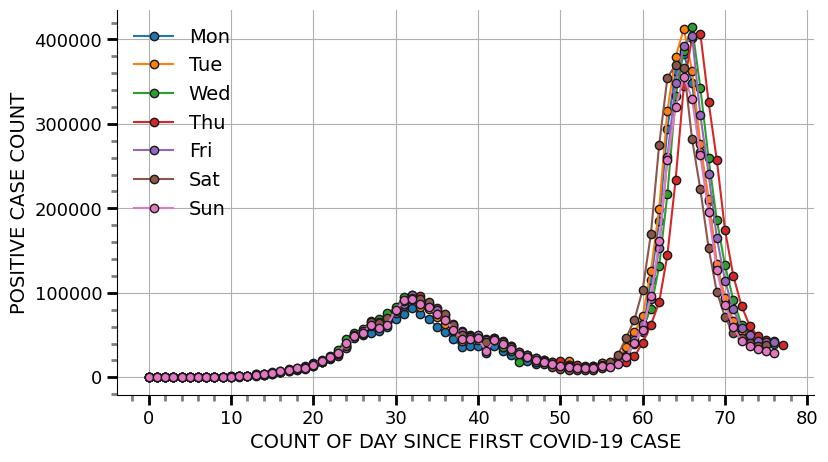

In [7]:
#collapse
dataset = {}
dataset['month'] = []
dataset['day'] = []
dataset['year'] = []

dataset['dailyconfirmed'] = daily_cases['dailyconfirmed']
dataset['dailyrecovered'] = daily_cases['dailyrecovered']
dataset['dailydeceased'] = daily_cases['dailydeceased']

# date creation
for date in total_cases['date']:
    day = int(date.split(' ' )[0])
    month = date.split(' ')[1]
    if month == 'January':
        month_val = 1
    if month == 'February':
        month_val = 2
    if month == 'March':
        month_val = 3
    if month == 'April':
        month_val = 4
    if month == 'May':
        month_val = 5
    if month == 'June':
        month_val = 6
    if month == 'July':
        month_val = 7
    if month == 'August':
        month_val = 8
    if month == 'September':
        month_val = 9
    if month == 'October':
        month_val = 10
    if month == 'November':
        month_val = 11
    if month == 'December':
        month_val = 12
    year_val = 2020
    day_val = datetime.datetime(year_val, month_val, day).strftime("%A")
    # push into dict
    dataset['day'].append(day_val)
    dataset['month'].append(month_val)
    dataset['year'].append(year_val)
    
df = pd.DataFrame.from_dict(dataset)

label_day = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.subplots(figsize=[9,5])
ax = plt.subplot(1,1,1)
day_mu = []
for i in label_day:
#     if i == 'Monday' or i == 'Saturday':
        temp = df[df['day']==i]['dailyconfirmed'].values
        ax.plot(temp,'-',label=i[:3],marker='o',markeredgecolor='k')
        day_mu.append(np.mean(df[df['day']==i]['dailyconfirmed']))
        ax.grid(True)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
ax1.grid(color='gray', linestyle='--', linewidth=1,alpha=.1)
ax.set_xlabel('COUNT OF DAY SINCE FIRST COVID-19 CASE',fontsize=14)
ax.set_ylabel('POSITIVE CASE COUNT',fontsize=14)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='gray')
ax.legend(frameon=False,fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()


## Plotting state-wise data

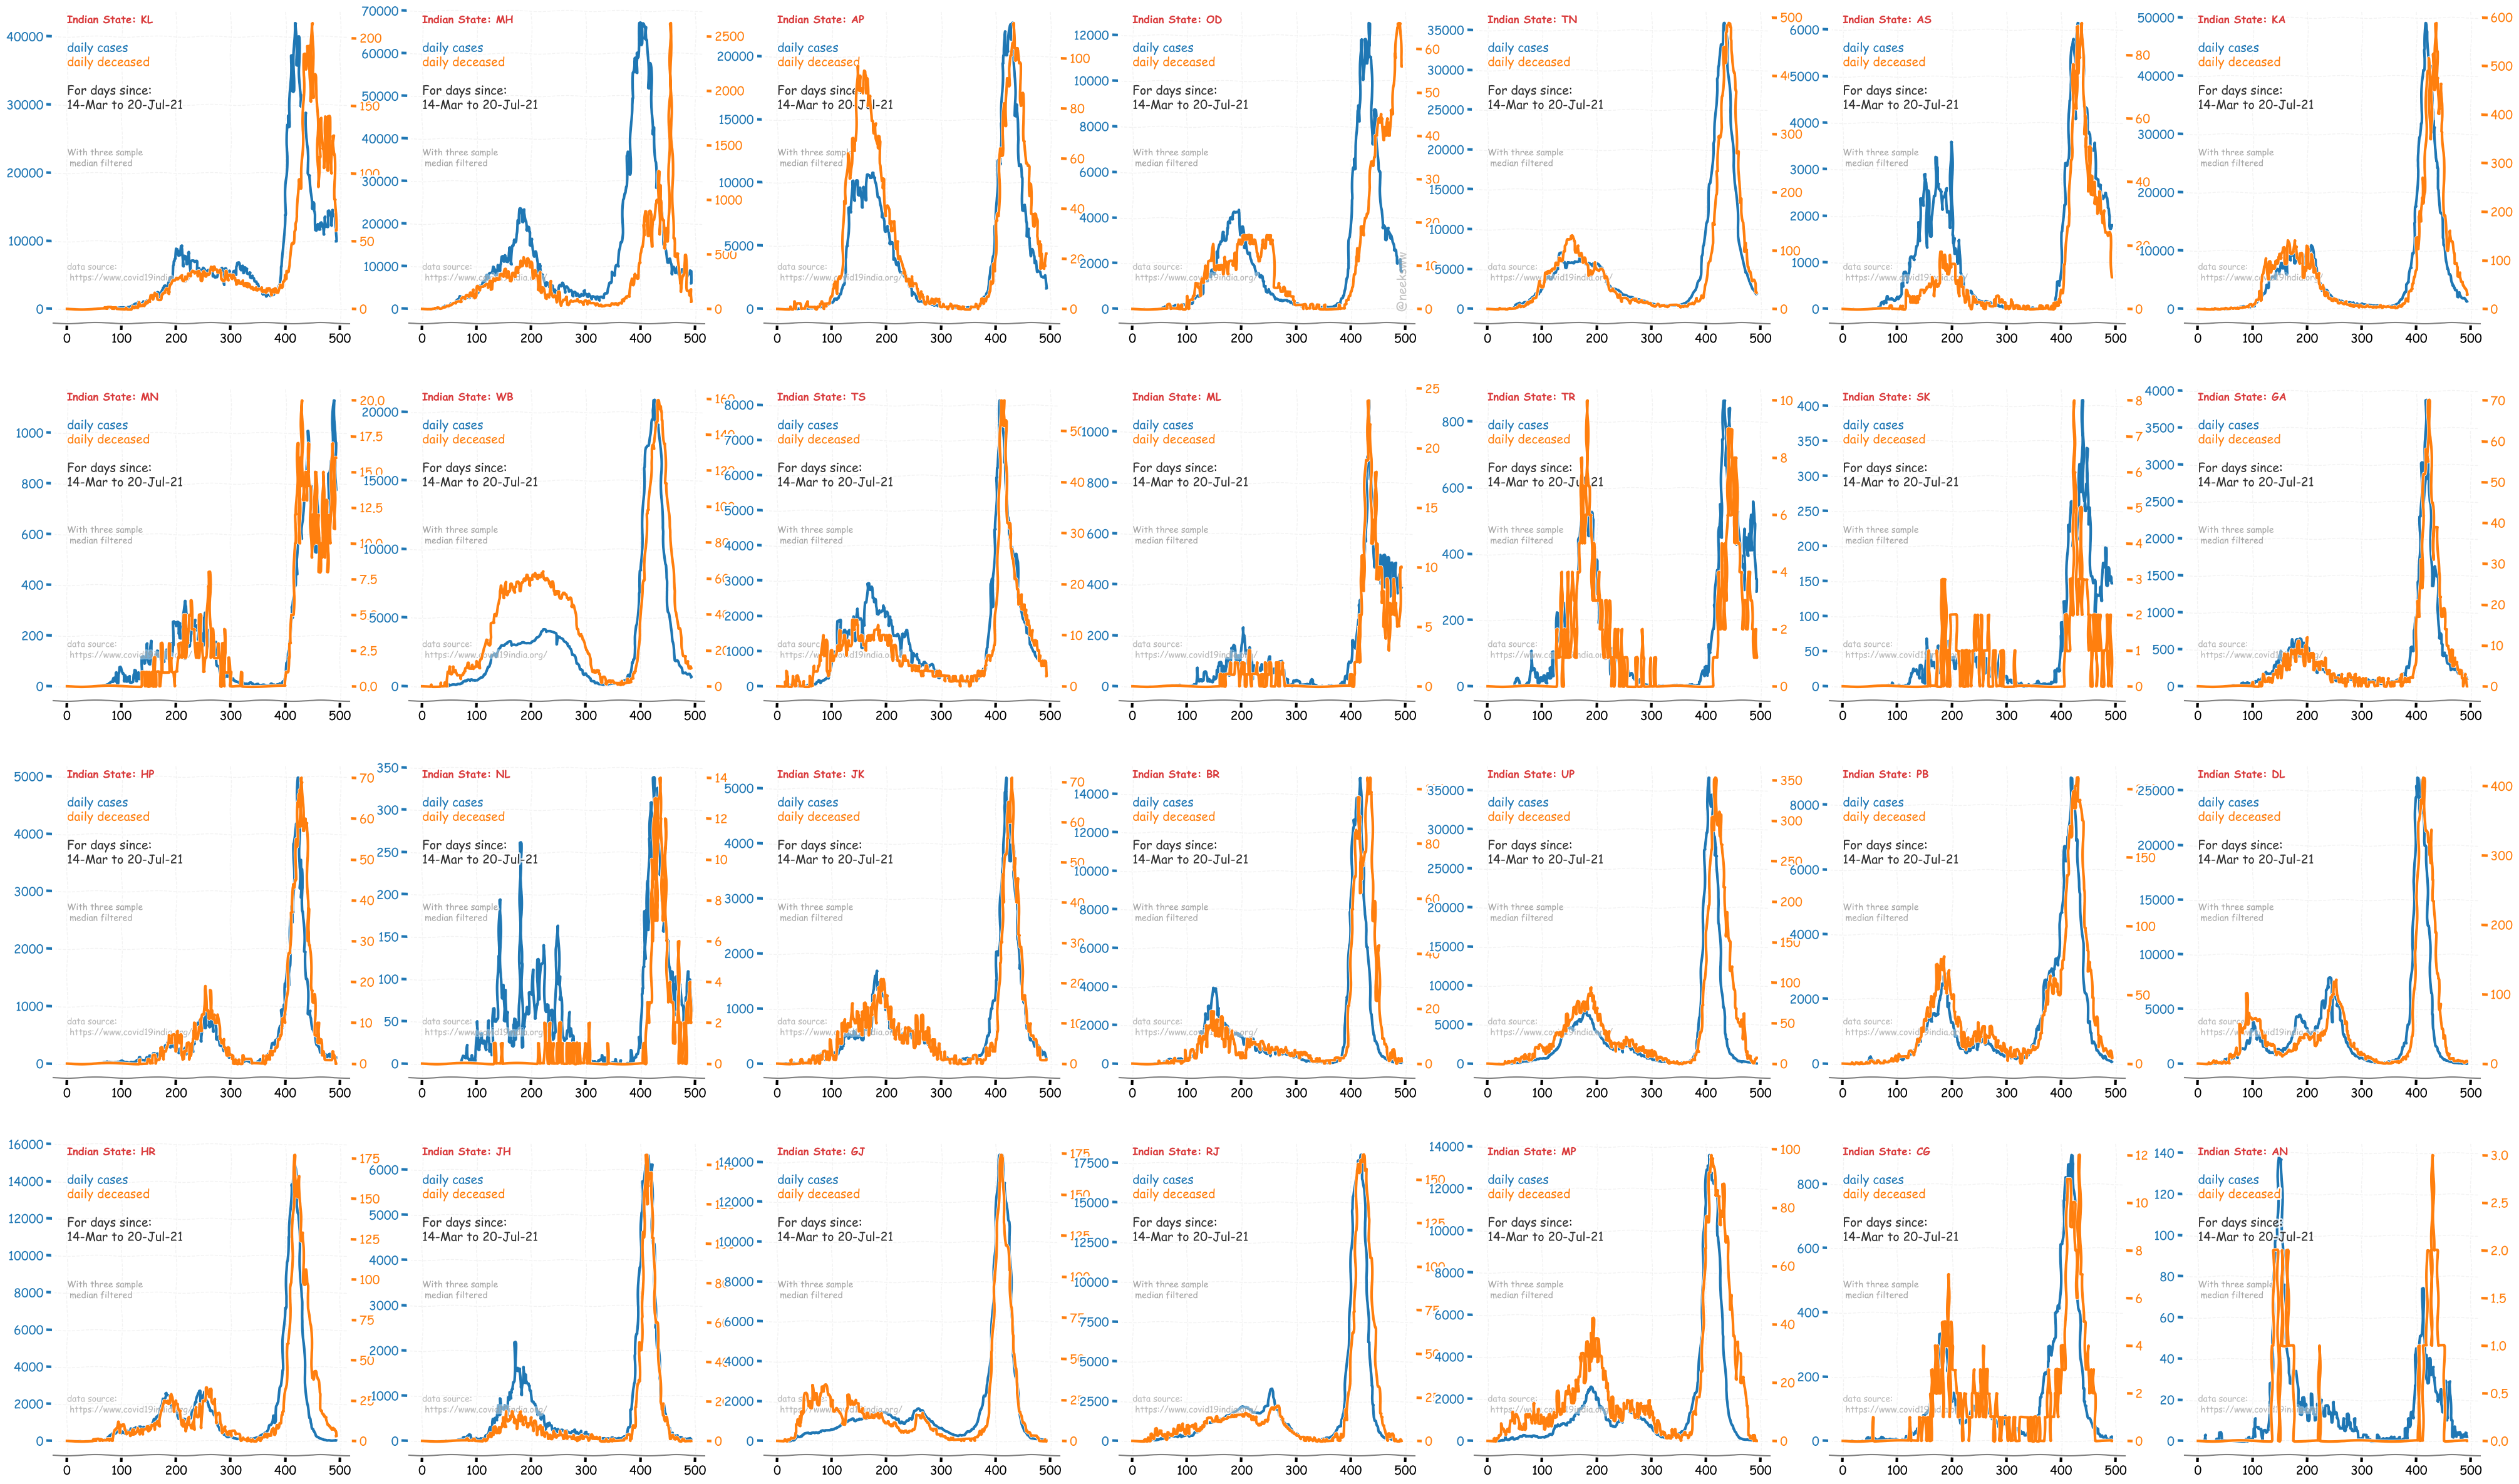

In [8]:
#collapse
df = pd.read_csv('./my_data/covid/tested_numbers_icmr_data.csv')
dates = df["Tested As Of"].values
daily_RTPCR_tets = df["Daily RTPCR tests"].values

temp = df["Total Samples Tested"].values
temp = df["Total Positive Cases"].values

df = pd.read_csv('./my_data/covid/state_wise_daily.csv')
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')


# temp_1 = normalize(temp_1,norm='max', axis=0)
state_labels = ['KA','TN','MH','DL','GJ','KL']
state_labels = ['MH','KA','AP','UP','TN','RJ','TG','AS','CH','KL','DL','BR',\
                'GJ','OR','WB','HR','JK','HP','MP','PB','NL','GA','JH','AN',\
                'MN','ML','SK','TR',
               ]
state_labels_= ['MH','KA','AP','UP','TN','RJ','TS','AS','CG','KL','DL','BR',\
                'GJ','OD','WB','HR','JK','HP','MP','PB','NL','GA','JH','AN',\
                'MN','ML','SK','TR'
               ]


clr_1 = 'tab:blue'
clr_2 = 'tab:orange'

cnt = 0
start_cases = []
start_decea = []
current_cases = []

for i in state_labels:
    cnt+= 1
    start_cases.append(np.where(np.cumsum(df[df['Status']=='Confirmed'][i].values)>5)[0][0])
    start_decea.append(np.where(np.cumsum(df[df['Status']=='Deceased'][i].values)>5)[0][0])
    current_cases.append(df[df['Status']=='Confirmed'][i].values[-1])

indx = np.argsort(current_cases)[::-1]   

fig = plt.subplots(figsize=[50,30])
cnt = 0
all_states_cases = []
all_states_decea = []

plt.xkcd()
for i in indx:
    cnt+= 1
    ax1 = plt.subplot(4,7,cnt)
    ax2 = ax1.twinx()  
    
    temp_1 = medfilt(df[df['Status']=='Confirmed'][state_labels[i]].values,3)
    all_states_cases.append(temp_1/max(temp_1))
#     temp_1 = savgol_filter(df[df['Status']=='Confirmed'][state_labels[i]].values,window_length=7, polyorder=1,\
#                            deriv=0, delta=1.0, axis=0, mode='nearest')
    
    temp_2 = medfilt(df[df['Status']=='Deceased'][state_labels[i]].values,3)
    all_states_decea.append(temp_2/(max(temp_2)))
#     temp_2 = savgol_filter(df[df['Status']=='Deceased'][state_labels[i]].values,window_length=7, polyorder=1,\
#                            deriv=0, delta=1.0, axis=0, mode='nearest')

    ax1.plot(np.arange(0,len(temp_1),1),temp_1,color=clr_1, linewidth=3)
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.spines['bottom'].set_color('gray')
    ax1.tick_params(axis='y', colors=clr_1)
    ax2.tick_params(axis='x', colors='gray')
    ax1.text(0,max(temp_1)-0.0*max(temp_1),'Indian State: '+state_labels_[i],fontsize=12,color='tab:red',alpha=0.9,
            fontweight='bold')
#     ,\bbox=dict(facecolor='gray', alpha=0.2))
    ax1.text(0,max(temp_1)-0.1*max(temp_1),'daily cases',fontsize=14,color=clr_1)
    ax1.text(0,max(temp_1)-0.15*max(temp_1),'daily deceased',fontsize=14,color=clr_2)
    ax1.text(0,max(temp_1)-0.3*max(temp_1),'For days since:\n'+ df['Date'][0].split('-20')[0] +' to '+\
             df['Date'][len(df)-1].split('-20')[0],fontsize=14,color='black',alpha=0.75)
    ax1.text(0,max(temp_1)-0.5*max(temp_1),'With three sample\n median filtered',fontsize=10,color='gray',
                 rotation=0,alpha=0.6)
    ax1.text(0,max(temp_1)-0.9*max(temp_1),'data source:\n https://www.covid19india.org/',fontsize=10,color='gray',
                 rotation=0,alpha=0.4)
    if cnt == 4:
        ax1.text(len(temp_1)-10,0,'@neeksww',fontsize=14,color='gray',
                 rotation=90,alpha=0.3)
    ax1.grid(color='gray', linestyle='--', linewidth=1,alpha=.1)
    
    ax2.plot(np.arange(0,len(temp_2),1),temp_2,color=clr_2, linewidth=3)
    ax2.tick_params(axis='x', labelcolor=clr_2)    
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('none')
    ax2.spines['bottom'].set_color('gray')
    ax2.tick_params(axis='y', colors=clr_2)

#     clr_face = (79/256,178/256,151/256)
#     ax1.set_facecolor(clr_face)
#     ax2.set_facecolor(clr_face)


fmt = 'png'
plt.savefig('/Users/neeks/Desktop/Documents/work/code/python_codes/notebookCodes/coswara/figures/'\
                  +'covid_status_india.'+fmt, dpi=300, format=fmt,transparent=False,bbox_inches='tight')
plt.show()

In [9]:
#collapse
if 0:
    len(all_states_cases[0])
    x = signal.correlate(all_states_cases[0],all_states_cases[4])
    print(396-np.argmax(x))
    print(x.shape)
    plt.plot(x.T)
    plt.show()

    fig, ax = plt.subplots(figsize=[12,6])
    for i in range(len(all_states_cases)):
        plt.plot(all_states_cases[i])
    plt.show()


    fig, ax = plt.subplots(figsize=[12,6])
    im = ax.imshow(all_states_cases,origin='lower',aspect='auto',extent =\
                   [0,temp_1.shape[0], 0, len(all_states_cases)],
                   cmap='Blues',vmin = 0, vmax =1)
    divider = make_axes_locatable(ax)
    colorbar_ax = fig.add_axes([.95, 0.1, 0.015, 0.5])
    fig.colorbar(im, cax=colorbar_ax)
    plt.show()

    fig, ax = plt.subplots(figsize=[12,6])
    im = ax.imshow(all_states_decea,origin='lower',aspect='auto',extent =\
                   [0,temp_1.shape[0], 0, len(all_states_cases)],
                   cmap='Blues',vmin = 0, vmax =1)
    divider = make_axes_locatable(ax)
    colorbar_ax = fig.add_axes([.95, 0.1, 0.015, 0.5])
    fig.colorbar(im, cax=colorbar_ax)
    plt.show()

Thats' it for now!